<h1><center> Telco Classification Project</center></h1>


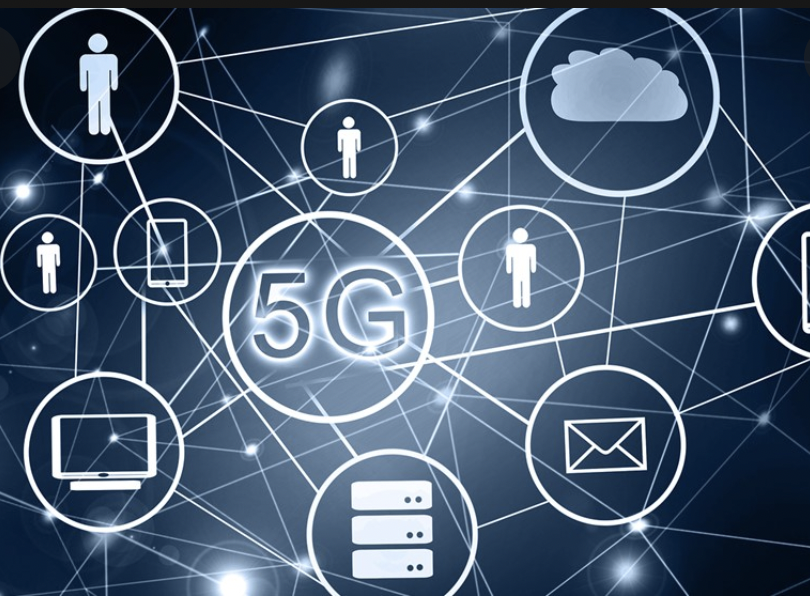

## Planning

### Goals
- Determine drivers of churn.
- Make recommendations to reduce churn.
- Create a model that predicts customer churn.

### Executive Summary
- Key Findings: Drivers of churn are family types, payment type, fiber optic internet, and add-on services.


- Recommendations: 
    - Offer senior citizen discounts
    - strategize marketing to younger families
    - discourage use of electronic checks (incenvtivize other payment options)
    - offer discounts for bundled add-on services with Fiber Optic internet.

- Multiple models were created, fit, and evaluated. 
    - Logistic Regression was chosen as the best model as its accuracy was above baseline and the recall rate was the highest of all the other models. This model performed at 75% accuracy with a recall rate of 79% on the positive case.
- Next Steps: Additional evaluation on fiber optic internet.



In [2]:
import pandas as pd
import numpy as np
import os
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from env import get_db_url
import acquire
import prepare

alpha = .01

## Acquire 

- Data acquired from local file or Codeup database.

In [3]:
# acquire Telco data from Codeup database and save as .csv
df = acquire.get_telco_data()

## Prepare
- Data was prepared by dropping 11 rows in which total_charges was missing values.
    - These customers were too new to accrue charges.
- Categorical columns were encoded.
- The following columns were dropped as they were duplicated within the data:
    - payment_type_id
    - contract_type_id
    - internet_service_type_id

In [4]:
# clean data to drop unnecessary columns, encode categorical data with one-hot encoding, 
# change total charges to numerical data, and drop nulls
df = prepare.clean_telco_data(df)

In [5]:
# split data into train, validate, test sets
# display the split sets and confirm stratification
train, validate, test = prepare.split_telco_data(df)
train.shape, validate.shape, test.shape

((3937, 46), (1688, 46), (1407, 46))

## Explore
    
- Exploratory analysis occuring on training dataset only.

- Questions to answer:
    - Does contract type matter?
    - Do those that churn pay more?
    - Does family type drive churn rates?
        -Explore gender, senior citizens, customers with dependents and partners.
    - Does payment type matter?
    - Does phone type or internet type lead to churn?
    - How do add-on services affect churn?
    
    

### Churn Overview

<AxesSubplot:title={'center':'Customers with month-to-month contracts churn more frequently'}, xlabel='contract_type', ylabel='count'>

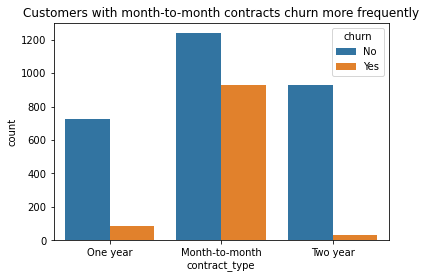

In [7]:
# visualize contracts types and churn
plt.title('Customers with month-to-month contracts churn more frequently')
sns.countplot(data=train, x='contract_type', hue='churn')

<AxesSubplot:title={'center':'Customers that churn are paying more'}, xlabel='churn', ylabel='monthly_charges'>

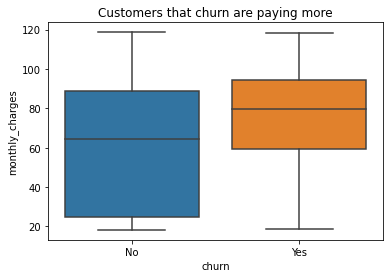

In [8]:
# visualize monthly charges with churn
plt.title('Customers that churn are paying more')
sns.boxplot(data=train,  y='monthly_charges', x='churn')

Null hypothesis: The mean of monthly charges of churned customers <= the mean of monthly charges of all customers

Alternative hypothesis: The meean of monthly charges of churned customers > the mean of monthly charges of all customers

In [9]:
# apply hypothesis testing (t-test) to determine if the mean of monthly charges of customers who churn is 
# significantly higher than the mean across all customers
churned = train[train.churn == 'Yes'].monthly_charges
churned = train[train.churn == 'Yes'].monthly_charges
pop_mean = train.monthly_charges.mean()

t, p = stats.ttest_1samp(churned, pop_mean)
t,p

(13.037366230308015, 4.1597964256756695e-36)

In [10]:
if p/2 > alpha:
    print("Fail to reject the null")
elif t < 0:
    print("Fail to reject the null")
else:
    print("Reject the null that the mean of monthly charges of churned customers <= the mean of monthly charges of all customers")

Reject the null that the mean of monthly charges of churned customers <= the mean of monthly charges of all customers


#### **Takaeaways:**
- Customers with month-to-month contracts churn more frequently
- Those that churn have, on average, higher monthly bills.
    - Hypothesis testing shows that the mean monthly charges of customers that churn is significantly higher than the mean of all customers


### Churn and Customer Demographics 

<AxesSubplot:title={'center':'Senior citizens churn more frequently'}, xlabel='senior_citizen', ylabel='count'>

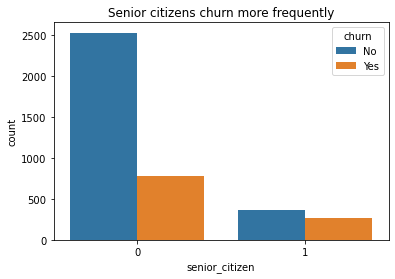

In [12]:
# visualize senior citizens and churn
plt.title('Senior citizens churn more frequently')
sns.countplot(data=train, x='senior_citizen', hue ='churn')

In [13]:
# find percentage of senior citizens that churn
df[df.senior_citizen == 1].churn.value_counts(normalize=True)

No     0.583187
Yes    0.416813
Name: churn, dtype: float64

Null Hypothesis: Churn and being a senior citizen are independent.

Alternative Hypothesis: Churn and being a senior citizen are dependent.

In [14]:
# display crosstab between senior citizen status and churn
observed = pd.crosstab(train.senior_citizen, train.churn)
observed

churn,No,Yes
senior_citizen,,
0,2527,775
1,364,271


In [15]:
# find the value of p by performing stats chi2 test
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

1.7561315684822695e-23

In [16]:
if p < alpha:
    print("Reject the null hypothesis that Churn and being a senior citizen are independent")
else:
    print("Fail to reject the null")

Reject the null hypothesis that Churn and being a senior citizen are independent


<AxesSubplot:title={'center':'Customers without dependents are more likely to churn'}, xlabel='dependents', ylabel='count'>

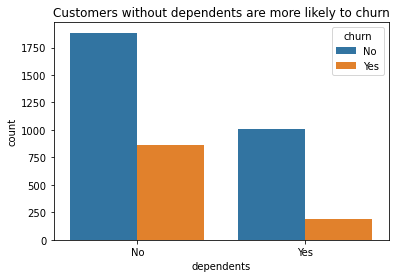

In [17]:
# visualize dependents and churn
plt.title('Customers without dependents are more likely to churn')
sns.countplot(data=train, x='dependents', hue ='churn')

<AxesSubplot:title={'center':'Customers without partners are more likely to churn'}, xlabel='partner', ylabel='count'>

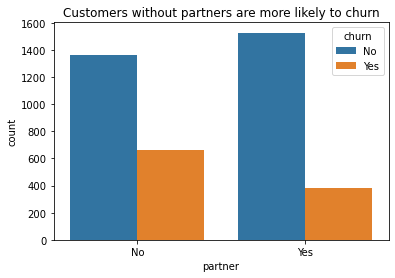

In [18]:
# visualize partners and churn
plt.title('Customers without partners are more likely to churn')
sns.countplot(data=train, x='partner', hue ='churn')

#### **Takaeaways:**
- Gender does not appear to be an indicator of churn.
- 42% of seniors have churned.
    - Hypothesis testing supports that the relationship between senior citizen status and churn are depdendent.
- Customers without dependents and partners are more likely to churn.

### Churn and Payment Type

<AxesSubplot:title={'center':'Customers that pay by electronic check are more likely to churn'}, xlabel='churn', ylabel='count'>

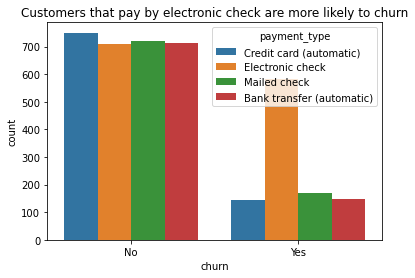

In [19]:
# visualize payment types and churn
plt.title('Customers that pay by electronic check are more likely to churn')
sns.countplot(data=train, x='churn', hue ='payment_type')

Null hypothesis: There is no relationship between churn and electronic check payment type.

Alternative hypothesis: There is a relationship between churn and electronic check payment type.

In [20]:
# display crosstab between electronic check payment type and churn
observed = pd.crosstab(train.payment_type == 'Electronic check', train.churn)
observed

churn,No,Yes
payment_type,,
False,2183,465
True,708,581


In [21]:
# find the value of p by performing stats chi2 test
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

7.910587922260644e-75

In [22]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Reject the null hypothesis


#### **Takaeaways:**
- Customers that pay by electronic check are more likely to churn.
    - Hypothesis testing supports that there is a relationship between electronic check payments and churn.

### Churn and Internet Services

<AxesSubplot:title={'center':'Customers with Fiber optic internet are more likely to churn'}, xlabel='churn', ylabel='count'>

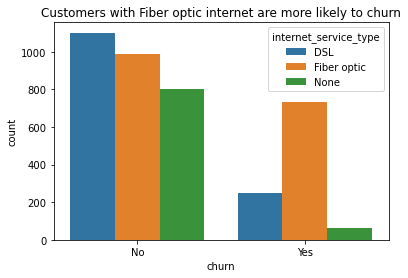

In [25]:
# visualize internet services and churn
plt.title('Customers with Fiber optic internet are more likely to churn')
sns.countplot(data=train, x='churn', hue ='internet_service_type')

Null Hypothesis: Churn and internet service type are independent.

Alternative Hypothesis: Churn and internet service type are dependent.

In [26]:
# display crosstab between internet service type and churn
observed = pd.crosstab(train.internet_service_type, train.churn)
observed

churn,No,Yes
internet_service_type,,
DSL,1101,247
Fiber optic,987,735
None,803,64


In [27]:
# find the value of p by performing stats chi2 test
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

3.2062272759526154e-96

In [28]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Reject the null hypothesis


#### **Takaeaways:**
- Phone service or having multiple phone lines does not appear to be an indicator of churn.
- Customers with Fiber Optic internet churn more frequently.
    - Hypothesis testing rejects the null that internet service type and churn are independent.


### Churn and Add-on Services

Text(0.5, 1.0, 'Customers without online security are more likely to churn')

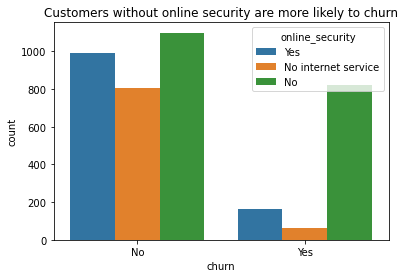

In [29]:
# explore add-on services and churn
sns.countplot(data=train, x='churn', hue ='online_security')
plt.title('Customers without online security are more likely to churn')

<AxesSubplot:title={'center':'Customers without online backup are more likely to churn'}, xlabel='churn', ylabel='count'>

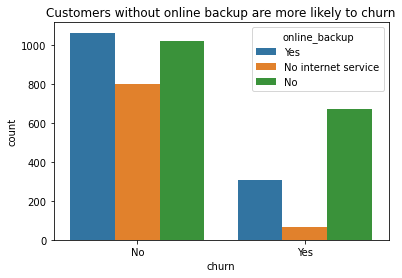

In [30]:
plt.title('Customers without online backup are more likely to churn')
sns.countplot(data=train, x='churn', hue ='online_backup')

<AxesSubplot:title={'center':'Customers without tech support are more likely to churn'}, xlabel='churn', ylabel='count'>

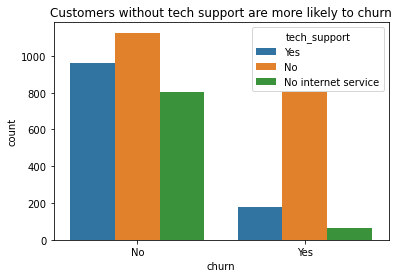

In [31]:
plt.title('Customers without tech support are more likely to churn')
sns.countplot(data=train, x='churn', hue ='tech_support')

Null hypothesis: Churn and tech support are independent.

Alternative hypothesis: Churn and tech support are dependent.

In [32]:
observed = pd.crosstab(train.tech_support, train.churn)
observed

churn,No,Yes
tech_support,,
No,1126,805
No internet service,803,64
Yes,962,177


In [33]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

8.373959266633126e-101

In [34]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Reject the null hypothesis


#### **Takaeaways:**
- Customers without online security, online backup, or tech support are more likely to churn.
    - Chi Squared testing infers that the relationship between tech support and churn are dependent 

## Answers to Initial Questions   
- Customers with month-to-month contracts churn more frequently.
- The mean monthly charges of customers that churn is significantly higher than the mean of all customers.
- Senior citizens, customers without dependents, and customers without partners churn more often.
- There is a relationship between electronic checks and churn.
- There is a relationship between internet service type and churn. 
- Customers without online security, online backup, or tech support churn more often.
    
### Recommendations
   - Offer senior citizen discounts.
   - Strategize marketing to younger families.
   - Discourage use of elctronic checks (incentivize other payment types).
   - Offer discounted add-on services to Fiber Optic customers.
    
### Further analysis
   - With additional time, dive further into drivers of churn for Fiber Optic customers.
    

## Modeling
- Multiple classification models were created, trained, and validated.
    - Decision Tree - max depth of 2 through 19
    - Random Forests - max depth of 2 through 19
    - K-Nearest Neighbor - k = 3 through 21
    - Logistic Regression 
    
- Models were chosen to maximize recall as to limit any False Negatives.
- Testing was performed on the best fit model with an accuracy of 75% and a recall of 79%.

### Best fit models
- Decision Tree with max depth of 4
- Random Forest with max depth of 7
- Logistic Regression

#### Baseline model is ~73% accurate.

In [32]:
# determine baseline accuracy
train.has_churned.value_counts(normalize=True)

0    0.734315
1    0.265685
Name: has_churned, dtype: float64

In [33]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 
# values to be used on all models
X_train = train.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_train = train.has_churned

X_validate = validate.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_validate = validate.has_churned

X_test = test.drop(columns=['customer_id', 'gender', 'partner', 'dependents',\
                              'phone_service', 'multiple_lines', 'online_security',\
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv',\
                              'streaming_movies', 'paperless_billing', 'churn', 'contract_type',\
                              'internet_service_type', 'payment_type', 'has_churned', 'is_female'])
y_test = test.has_churned


### Decision Tree

- The decision tree model with a max depth of 4 has a train accuracy of 80% and a validation accuracy of 78% which out performs the baseline model. 


In [34]:
# create the decision tree
clf = DecisionTreeClassifier(max_depth=4, random_state=123)

In [35]:
# fit the model
clf = clf.fit(X_train, y_train)

In [36]:
# make prediction on train obeservations
y_pred1 = clf.predict(X_train)
y_pred_proba1 = clf.predict_proba(X_train)

#### In-sample accuracy ~ 80%

In [37]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.80


#### Out-of-sample accuracy ~ 78%

In [38]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))


Accuracy of Decision Tree classifier on validate set: 0.78


### Random Forest
- The random forest model with a max depth of 7 has a train accuracy of 82% and a validation accuracy of 80%.

In [39]:
# create the model
rf = RandomForestClassifier(max_depth=7, random_state=123)

In [40]:
# fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, random_state=123)

#### In-sample accuracy ~ 82%

In [41]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.82


#### Out-of-sample accuracy ~ 80%

In [42]:
print('Accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on validate set: 0.80


### Logistic Regression 

- The logistic regression model has a training accuracy of 76% with a validation accuracy of 73%.

In [43]:
# create the model
logit = LogisticRegression(class_weight='balanced', random_state=123, solver='lbfgs')

In [44]:
# fit the model
logit.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=123)

#### In-sample accuracy ~ 76%

In [45]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.76


#### Out-of-sample accuracy ~ 73%

In [18]:
print('Accuracy of Logistic Regression classifier on validate set: {:.2f}'
     .format(logit.score(X_validate, y_validate)))

Accuracy of Logistic Regression classifier on validate set: 0.73


### Best model - Logistic Regression Model  
- This model had 76% accuracy on train data and 73% on validation data. However, the model had the highest recall rate on the posiive case. The most costly event would be a false negative, predicting a customer did not churn, when in fact, they did churn. While other models would be more accurate, this model was chosen specifically for its optimization for reducing false negatives.
- This model performed at 75% accuracy on the test dataset with 79% recall on the positive case.

#### Test accuracy ~ 75%  Recall - 79%

In [30]:
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'
     .format(logit.score(X_test, y_test)))

Accuracy of Logistic Regression classifier on test set: 0.75


In [31]:
y_pred = logit.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1033
           1       0.51      0.79      0.62       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.76      1407



### Predictions

In [46]:
# create dataframe with predictions and probablities from test dataset
predictions = pd.DataFrame(np.round(logit.predict_proba(X_test),2))
predictions['prediction'] = logit.predict(X_test)

In [47]:
# clean predictions dataframe
predictions = predictions.set_index(test.customer_id)
predictions.drop(columns=[0], inplace=True)
predictions.rename(columns={1:"probability_of_churn"},inplace=True)
predictions.head()

,probability_of_churn,prediction
customer_id,,
4716-MRVEN,0.07,0
8966-KZXXA,0.05,0
8720-RQSBJ,0.74,1
7504-UWHNB,0.65,1
1730-VFMWO,0.20,0


In [56]:
# save predictions df to csv file
predictions.to_csv("predictions.csv")